# Progetto A.A 2020-2021

<strong>Programmazione di Applicazioni Data Intensive</strong><br>
Arcara Alessio <br> alessio.arcara@studio.unibo.it <br> Matricola: 0900061028<br>
<a href="https://www.kaggle.com/aaron7sun/stocknews">Kaggle: Daily News for Stock Market Prediction</a>

## Introduzione

Il dataset scelto è composto da due file *csv* :
1. <strong>Stocks data</strong>: Indice Dow Jones Industrial Average (DJIA) composto dalle trenta imprese industriali statunitensi più redditizie del mercato. <br>*(Range: 2008-08-08 to 2016-07-01)*
2. <strong>News data</strong>: i titoli dei post dal canale Reddit WorldNews (<a href="https://www.reddit.com/r/worldnews/">/r/worldnews</a>). Sono classificate con i voti degli utenti reddit, e solo i 25 migliori titoli sono considerati per singolo giorno. <br>*(Range: 2008-06-08 to 2016-07-01)*

Le <strong>32</strong> colonne considerate sono le seguenti:
- "Date" (*intervallo*) $\rightarrow$ data giornaliera di scambio del titolo azionario,
- "Open, High, Low, Close, Adj Close" (*numerica*) $\rightarrow$ prezzo di apertura, chiusura e prezzo minimo, massimo giornaliero del titolo azionario.
- "Volume" (*ratio*) $\rightarrow$ quantità scambiata giornalmente del titolo azionario.
- "Top1,...,Top25" (*testo*) $\rightarrow$ i titoli dei migliori 25 post giornalieri del canale Reddit WorldNews.

Le istanze fornite sono <strong>1989</strong> e la variabile da predire "Label", che verrà creata e spiegata nel dettaglio nelle seguenti sezioni, è una variabile discreta multiclasse (-1, 0, 1). 

### È possibile prevedere il mercato?

Una "passeggiata aleatoria" è un fenomeno statistico in cui una variabile non segue un andamento distinguibile e si muove apparentemente in modo casuale. La teoria del <strong>random walk</strong>, applicata ai mercati finanziari, delineata più chiaramente da Burton Malkiel, postula che il prezzo dei titoli si muove casualmente, e che, quindi, ogni tentativo di prevedere il movimento futuro dei prezzi, attraverso l'analisi fondamentale o tecnica, è inutile.

L'obiettivo è generare modelli in grado di prevedere se l'indice DJIA avrà al giorno $t$ un movimento rialzista o ribassista, in modo da generare un profitto investendo in un fondo che si basi su tale indice.

Il progetto è suddiviso in due parti:<br>

1. Nella prima parte verranno utilizzati i dati storici sull'andamento dell'indice DJIA per generare una predizione al tempo $t$ sul movimento rialzista (1) o ribassista (-1);
2. Nella seconda parte si utilizzerà il testo dei titoli dei post per cercare una correlazione tra l'andamento dell'indice DJIA e notizie generiche attraverso il <strong>Natural Language Process</strong> (NLP) e dunque, migliorare i risultati precedentemente ottenuti;

### Caricamento Librerie e Dati

In [1]:
rnd_state = 42

In [2]:
# Main
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import nltk

# Visualization
import matplotlib.pyplot as plt
from ipywidgets import interact
from matplotlib.lines import Line2D
import seaborn as sns

# Librerie RapidsAI
import cuml
import cudf
import cupy

In [3]:
# Disattiviamo i warning per leggibilità
import warnings
warnings.filterwarnings("ignore")  # Ignore deprecations for cleaner output

In [4]:
# Plot styling
%matplotlib inline
figsize=(25, 6)
plt.style.use('fivethirtyeight')

In [5]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/diaclo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/diaclo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stocks = pd.read_csv("./archive/upload_DJIA_table.csv", parse_dates=["Date"], index_col=["Date"])[::-1]

## Preprocessing

### Label dei dati
*(Fonte: Capitolo 3, Advances in Financial Machine Learning, Marcos López de Prado)*

I dati etichettati dicono al modello qual'è il risultato desiderato. Inoltre, se il modello effettua una predizione errata rispetto all'etichetta, si aggiusterà per avvicinarsi al risultato desiderato. <br>

Similmente, con le azioni, l'etichettatura del risultato fornisce al modello un indicazione sulla classificazione "<strong>Su</strong>" o "<strong>Giù</strong>" rispetto ai dati. Successivamente, l'idea è quella di classificare con "<strong>Su</strong>" o "<strong>Giù</strong>" nuovi dati non ancora visti.

Il metodo Naïve di etichettatura del risultato dell'andamento di un mercato finanziario è quello di basarsi solo sul <strong>segno</strong> del ritorno. Il principale svantaggio di quest'approccio è che non cattura la differenza di grandezza rispetto a due ritorni con lo stesso segno. *(0.01 ha lo stesso segno di 1000)*

Si potrebbe procedere aggiungendo una <strong>soglia</strong>, rispetto la quale si scelgono le etichette: <br><br>

<center>
$y_i= \begin{cases}
1 & r_{t_0, t_1} > \tau \\
0 & |{r_{t_0, t_1}}| \leq  \tau \\
-1 & r_{t_0, t_1} <  - \tau
\end{cases}$
</center>
<br>
Si migliora la precedente classificazione binaria, tuttavia la scelta della soglia statica assume che conseguentemente il mercato è statico. La varianza in un mercato finanziario è caratterizzata da un comportamento <strong>non costante</strong> <i>(volatility clustering)</i> e perciò per definizione l'andamento di un mercato finanziario è dinamico essendo una serie storica eteroschedatica.

Una soluzione è di introdurre una soglia dinamica basata sulla volatilità di $n$ periodi precedenti rispetto al prezzo di chiusura corrente. Si definisce la soglia come:

* $\pm\ \tau = $ Prezzo corrente $\pm$ volatilità $n$ periodi precedenti

In [7]:
def get_daily_vol(close, window=20):
    """
    Parameters:
    ---------------------
    close: (data frame) Closing Prices
    window: (int) periodo rispetto al quale calcolare volatility
    ---------------------
    Returns:
    ---------------------
    rolling std (data frame)
    ---------------------
    """
    print("Volatilità giornaliera per threshold dinamico")
    
    std = close.rolling(window).std()
    std.iloc[0:window] = close.iloc[0:window].std()
    
    return std

def get_label(close, std, threshold=1):
    """
    Parameters:
    ---------------------
    close: (data frame) Closing Prices
    std: (data frame) Rolling Std
    threshold: (int) Valore per controllare upper_bound, lower_bound
    ---------------------
    Returns:
    ---------------------
    Label (list)
    ---------------------
    """
    print("Etichettatura con threshold dinamico")
    
    upper_bound, lower_bound = close.shift(1)+std*threshold, close.shift(1)-std*threshold
    
    label = []
    for i in range(len(close)):
        if close.iloc[i] > upper_bound.iloc[i]:
            label.append(1)
        elif close.iloc[i] < lower_bound.iloc[i]:
            label.append(-1)
        else:
            label.append(0)
            
    return label

In [8]:
std = get_daily_vol(stocks["Close"])
label = pd.Series(get_label(stocks['Close'], std, 0.2)).astype("category")
# news["Label2"] = news["Label2"].astype("category")

Volatilità giornaliera per threshold dinamico
Etichettatura con threshold dinamico


In [9]:
label.index = news.index

NameError: name 'news' is not defined

In [ ]:
label.value_counts()

In [ ]:
# One day returns calculation through differencing by 1
stocks["Delta"] = (stocks["Close"] - stocks["Close"].shift(1))/stocks["Close"].shift(1) * 100
stocks.iloc[0, -1] = 0

In [ ]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(16,12))
label_colors = {1: "orange", 0: "black", -1: "green"}

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Label 1', markerfacecolor='orange', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Label 0', markerfacecolor='black', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Label -1', markerfacecolor='green', markersize=10)]

ax1.scatter(stocks.index, stocks["Delta"], s=20, alpha=0.4, c=news["Label"].map(label_colors))
ax2.scatter(stocks.index, stocks["Delta"], s=20, alpha=0.4, c=news["Label2"].map(label_colors));
ax1.set_title('Etichettatura binaria')
ax2.set_title('Etichettatura con soglia dinamica')
ax1.legend(handles=legend_elements[0:2], loc="upper right")
ax2.legend(handles=legend_elements, loc="upper right")
plt.show()

### Stazionarietà e differenziazione
*(Fonte: Capitolo 5, Advances in Financial Machine Learning, Marcos López de Prado)*

Comunemente le serie storiche finanziarie sono non stazionarie. Una <strong>serie storica non stazionaria</strong> è una serie per cui proprietà come <u>media, varianza, autocorrelazione, etc cambiano nel tempo</u>. <br>
Ora immaginiamo una situazione dove i dati che abbiamo utilizzato per creare il nostro modello di conoscenza siano significativamente differenti rispetto ai dati a regime. Questo porterà probabilmente il nostro estimatore ad avere una bassa performance.<br>

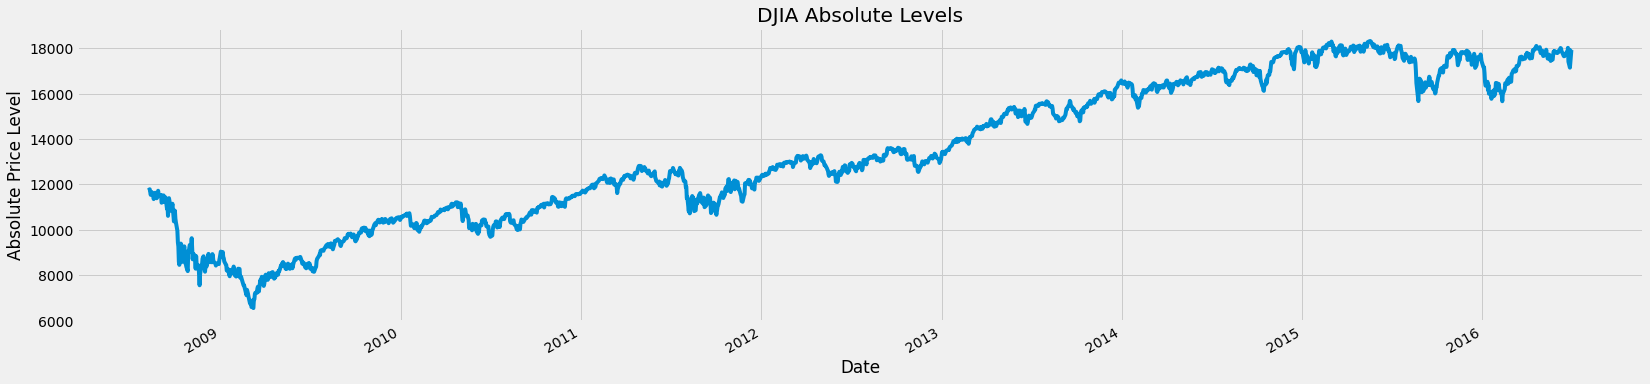

In [10]:
stocks["Adj Close"].plot(figsize=figsize)
plt.title('DJIA Absolute Levels');
plt.ylabel('Absolute Price Level')
plt.xlabel('Date');

Perciò, è auspicabile rendere la <strong>serie storica stazionaria</strong> mediante una o più trasformazioni, come per esempio trasformare i prezzi nei rendimenti di prezzo $y_t - y_{t-1}$.Tuttavia, queste trasformazioni rendono la serie stazionaria, a discapito di <u>perdere tutta la memoria</u> presente nella serie originale.<br>
Per memoria si intende come cambiamenti di osservazioni precedenti possono influenzare osservazioni future in un dato tempo. Se la serie avesse una forte memoria, analizzare il passato ci permetterebbe di ottenere informazioni su ciò che accade nel futuro.<br>

In [11]:
# Ritorni giornalieri
stocks["Delta"].plot(figsize=figsize)
plt.title(f'DJIA Daily Returns via Differencing 1 Day');
plt.ylabel('Daily Returns')

KeyError: 'Delta'

Verrà utilizzato un test statistico per controllare se la serie storica è stazionaria. il test, anche chiamato <strong>Augmented Dickey-Fuller</strong>, ha come ipotesi nulla che è presente un <strong>Unit root</strong>, ovvero che la serie storica modella un processo stocastico casuale, dove due valori qualsiasi di $y$ non hanno nessuna correlazione e sono effettivamente casuali. <u>Una serie storica con Unit root non è stazionaria</u>. <br><br>
Dunque, si utilizzerà la seguente funzione per controllare la stazionarità di una serie storica:

In [12]:
# test statistic < test statistic (1%) AND p-value < 0.01
# Reject the null hypothesis that there's unit root at the 1% significance level
# ==> Reject H0 ==> No unit root ==> Stationary

def adfuller_test(time_series, verbose=True):
    """
    Parameters:
    ---------------------
    time_series: (list) time series to evaluate
    ---------------------
    Returns:
    ---------------------
    null hypothesis (boolean)
    ---------------------
    """
    result = adfuller(time_series, regression='c')
    
    if verbose:
        print(f't-stat \n\t{result[0]:.2f}')
        print(f'p-value \n\t{result[1]:.2f}')
        print(f'Critical Values')
        for key, value in result[4].items():
            print(f'\t{key}: {value:.2f}')
        
    return True if result[0] > result[4]['1%'] or result[1] > 0.01 else False  

In [13]:
print(f'Null hypothesis: {adfuller_test(stocks["Adj Close"])}')

t-stat 
	-0.37
p-value 
	0.91
Critical Values
	1%: -3.43
	5%: -2.86
	10%: -2.57
Null hypothesis: True


In [14]:
print(f'Null hypothesis: {adfuller_test(stocks["Delta"])}')

KeyError: 'Delta'

Come possiamo vedere, il test statistico conferma ciò precedentemente descritto.

Per rendere la serie storica stazionaria e <u>minimizzare la perdita di memoria</u> si utilizzerà <strong>fractional differencing</strong>, introdotto per la prima volta nella pubblicazione scientifica <a href="https://www.jstor.org/stable/2335817">“Fractional Differencing”</a> da J. R. M. Hosking.

Denotiamo $B$ come operatore di spostamento all'indietro, una notazione che ci permette di scrivere in maniera compatta precedenti osservazioni della serie storica, dove ad esempio $B^kX_t=X_{t-k}$ per $k\geq0$ e $t>1$. I polinomi con questo tipo di operatore possono essere visti come una applicazione ripetuta dello spostamento all'indietro, ad esempio $B^2X_t=X_{t-2}$. <br>In un modello frazionario, l'esponente $d$ in $(1-B)^d$ può essere un numero reale, con la seguente espansione binomiale:

$$(1-B)^d=\sum_{k=0}^\infty\binom d k (-B)^k$$
$$=\sum_{k=0}^\infty\frac{\prod_{i=0}^{k-1}(d-i)(-B)^k}{k!}$$
$$=1-dB+\frac{d(d-1)}{2!}B^2-\frac{d(d-1)(d-2)}{3!}B^3+...$$

<br>
Consideriamo ora la serie $X_t$ con l'operatore di spostamento $(1-B)^d$:<br><br>
$$(1-B)^dX_t=X_t-dBX_t+\frac{d(d-1)}{2!}B^2X_t-...$$

Che può essere riscritta come:
$$X_t=X_t-dX_{t-1}+\frac{d(d-1)}{2!}X_{t-2}-...$$

$$\tilde{X}_t=\sum_{k=0}^\infty w_kX_{t-k}$$
<br>
<center>dove $w=${$1, -d, \frac{d(d-1)}{2!},...$} e $X=${$X_t, X_{t-1}, ...$}</center>

Possiamo perciò generare i pesi iterativamente come: 
$$w_k=-w_{k-1}\frac{d-k+1}{k}$$

<ul>
    <li>Quando $d$ è un numero intero, $\forall k>d = 0$ e la memoria dopo quel punto è azzerata, ad esempio $d=1$ $w=\{1, -1, 0, 0\}$</li>
    <li>I pesi convergono a zero, $w_k\rightarrow 0$</li>
    <li>L'alternanza del segno dei pesi è necessaria per mantenere la serie storica stazionaria</li>
</ul>

Plot weights [w] for each lag [k] for varying differencing value [d]
Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * (0.0 - k + 1)/k.
Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * (0.25 - k + 1)/k.
Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * (0.5 - k + 1)/k.
Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * (0.75 - k + 1)/k.
Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * (1.0 - k + 1)/k.


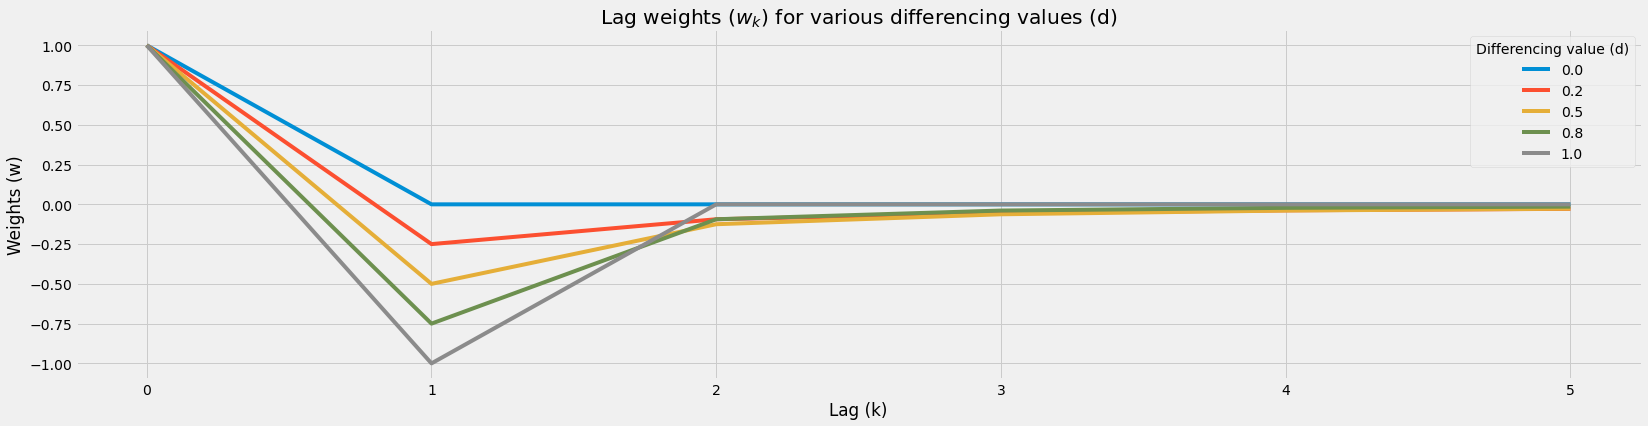

In [15]:
def get_weights(d, num_k):
    """
    Parameters:
    ---------------------
    d: (int) differencing value
    num_k: (int) number of lags (typically length of timeseries) to calculate w
    ---------------------
    Returns:
    ---------------------
    Label (list)
    ---------------------
    """
    print(f'Calcolo pesi [w] per ogni lag [k] come w_k = -w_(k-1) * ({d} - k + 1)/k.')
    
    w_k = np.array([1])
    
    for k in range(1, num_k):
        w_k = np.append(w_k, -w_k[-1] * ((d - k + 1)) / k)
        
    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def plot_weights(range_d, num_k, num_d_interval):
    """    
    Parameters:
    ---------------------
    range_d (list): range of differencing values to plot.
    num_k (int): number of lags (typically length of timeseries) to plot.
    num_d_interval (int): number of d interval.
    ---------------------
    Returns:
    ---------------------
    Weight for each d (dataframe)
    ---------------------
    """
    print("Plot weights [w] for each lag [k] for varying differencing value [d]")
    # Get differencing values
    interval = np.linspace(range_d[0], range_d[1], num_d_interval)
    
    # Dataframe of lags (rows) * number of differencing intervals (columns)
    df_wk = pd.DataFrame(np.zeros((num_k, num_d_interval)))
    
    # Get weights array per differencing value
    for i, d in enumerate(interval):
        df_wk[i] = get_weights(d, num_k)
        
    # Rename columns for legend
    df_wk.columns = [round(x, 1) for x in interval]
    
    # Plot
    df_wk.plot(figsize=figsize)
    plt.title('Lag weights ($w_k$) for various differencing values (d)')
    plt.legend(title='Differencing value (d)')
    plt.ylabel('Weights (w)')
    plt.xlabel('Lag (k)')
    plt.show()
    
    # Return weights
    return df_wk

df_wk = plot_weights(range_d=[0, 1], num_k=6, num_d_interval=5)


In [16]:
df_wk

,0.0,0.2,0.5,0.8,1.0
0,1.0,1.000000,1.000000,1.000000,1.0
1,-0.0,-0.250000,-0.500000,-0.750000,-1.0
2,-0.0,-0.093750,-0.125000,-0.093750,0.0
3,-0.0,-0.054688,-0.062500,-0.039062,0.0
4,-0.0,-0.037598,-0.039062,-0.021973,0.0
5,-0.0,-0.028198,-0.027344,-0.014282,0.0


Come si vede dal seguente grafico, alti valori di $d$ fanno decadere più velocemente la somma cumulativa del peso $w_k$, denotando una perdita di informazione maggiore rispetto alle osservazioni precedenti $X_{t-k}$.

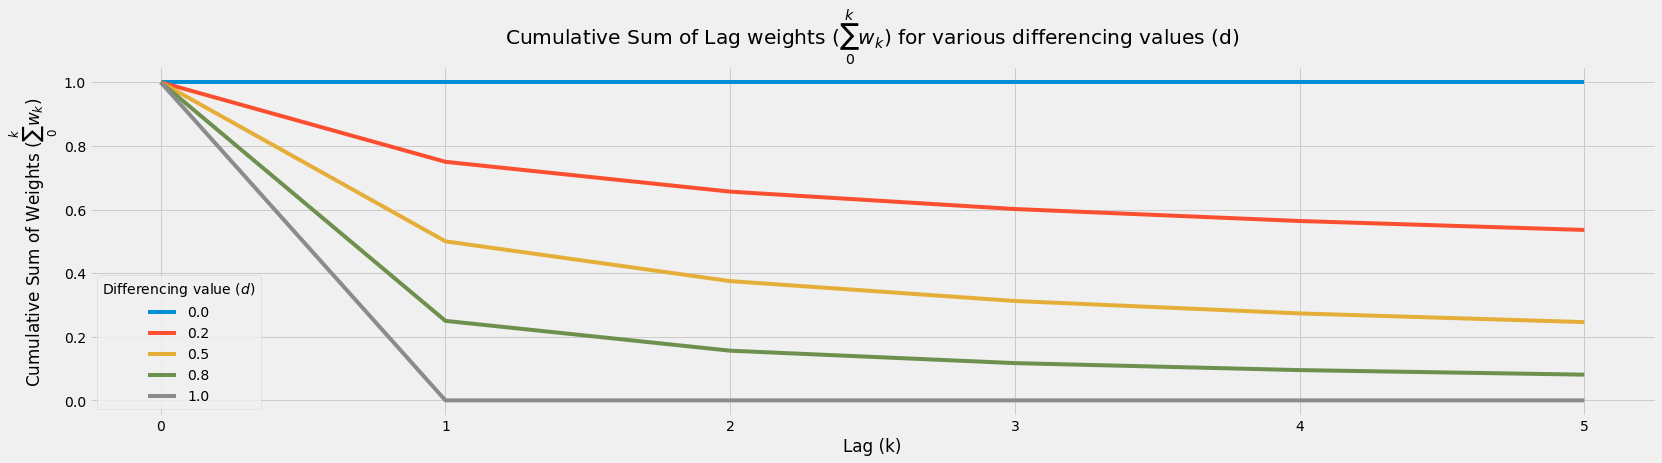

In [17]:
df_wk.cumsum().plot(figsize=figsize)
plt.title('Cumulative Sum of Lag weights ($\sum_0^k w_k$) for various differencing values (d)')
plt.legend(title='Differencing value ($d$)')
plt.ylabel('Cumulative Sum of Weights ($\sum_0^k w_k$)')
plt.xlabel('Lag (k)');

Per efficienza computazionale, se $|w_k|$ cade sotto un certo <strong>threshold</strong> si termina la computazione della funzione.<br> In altre parole, calcoliamo i primi $l*$ dove $|w_{l*}|\geq \tau$ e $|w_{l*+1}|\leq \tau$ tale che avremo:

$\tilde{w_k}=\begin{cases}
w_k & k\leq l* \\ 
0 & k>l*
\end{cases}$

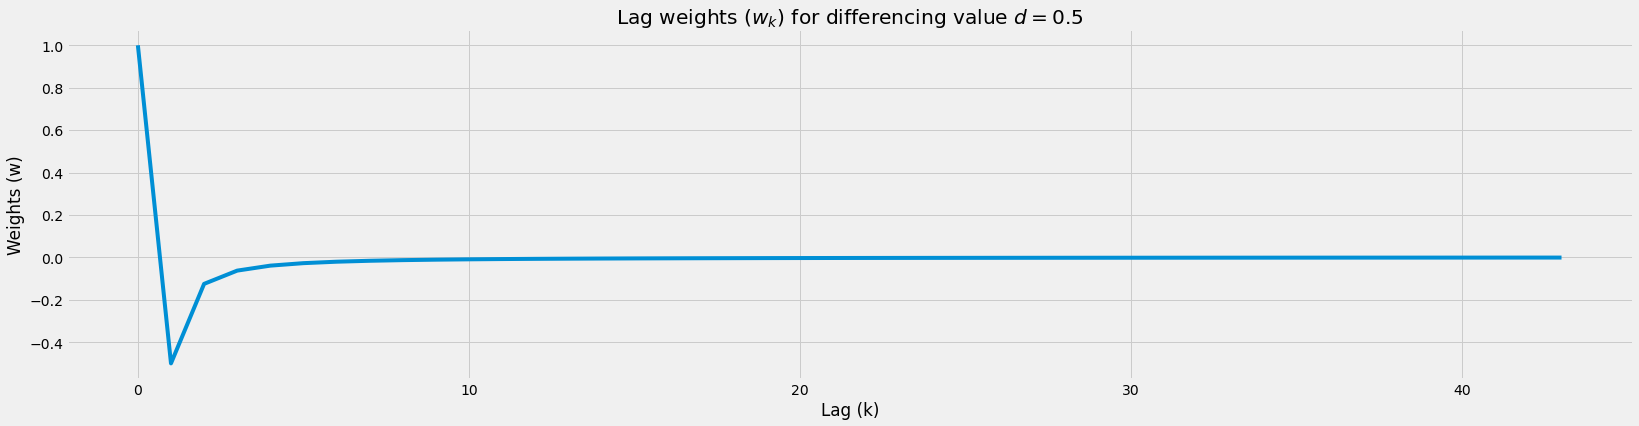

In [18]:
def get_weights_floored(d, num_k, floor=1e-3):
    """    
    Calculate weights [w] for each lag [k] through come $w_k = -w_(k-1) * (d - k + 1)/k$
    above a minimum value (floor) for the weights to prevent computation of weights for the entire time series
    
    Parameters:
    ---------------------
    d (int): differencing value.
    num_k (int): number of lags (typically length of timeseries) to calculate w.
    floor (float): minimum value for the weights for computational efficiency.
    ---------------------
    Returns:
    ---------------------
    Weight for each d (dataframe)
    ---------------------
    """
          
    w_k = np.array([1])
    k = 1
    
    while k < num_k:
        w_k_latest = -w_k[-1] * ((d - k + 1)) / k
        if abs(w_k_latest) <= floor:
            break

        w_k = np.append(w_k, w_k_latest)
        k += 1

    w_k = w_k.reshape(-1, 1) 
    return w_k

d = 0.5
num_k = 1000
weights = get_weights_floored(d=d, num_k=num_k)
pd.DataFrame(weights).plot(legend=False, figsize=figsize)

# Plot
plt.title(f'Lag weights ($w_k$) for differencing value $d={d}$')
plt.ylabel('Weights (w)')
plt.xlabel('Lag (k)');

In [19]:
def frac_diff(df, d, floor=1e-3):
    """
    Fractionally difference time series.
    
    Parameters:
    ---------------------
    df (dataFrame): dataframe of raw time series values.
    d (float): differencing value from 0 to 1.
    floor (float): minimum value of weights, ignoring anything smaller.
    ---------------------
    Returns:
    ---------------------
    Weight for each d (dataframe)
    ---------------------
    """
    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(df), floor=floor)
    weights_window_size = len(weights)
    
    # Reverse weights
    weights = weights[::-1]
    
    # Blank fractionally differenced series to be filled
    df_fd = []
    df_date = []

    # Slide window of time series, to calculated fractionally differenced values
    # per window
    for idx in range(weights_window_size, df.shape[0]):
        # Extract datetime from timestamp
        df_date.append(df.index[idx])
        # Dot product of weights and original values
        # to get fractionally differenced values
        df_fd.append(np.dot(weights.T, df.iloc[idx - weights_window_size:idx]).item())
    
    return pd.DataFrame(data=df_fd, index=df_date, columns=[df.name])

@interact(d=np.linspace(0, 1, 9))
def show_plot(d=0.1):
    df_raw_fd = frac_diff(stocks["Adj Close"], d=d, floor=5e-5)
    
    # Plot
    df_raw_fd.plot(figsize=figsize);
    plt.title(f'Time series differencing for value $d={d}$')
    plt.show()

interactive(children=(Dropdown(description='d', options=(0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0…

Data la funzione per eseguire il procedimento appena descritto, verrà costruita una funzione ricorrente <strong>min_d_frac_diff</strong> che calcolerà il valore $d$ che minimizza la perdita di memoria e rende stazionaria la serie storica. Questa, successivamente, verrà utilizzata nel <i>FunctionTransformer</i> di Scikit-Learn per trasformare le serie storiche non stazionarie.

In [20]:
def min_d_frac_diff(df, d=0):
    print(f"column: {df.name}, differencing value: {round(d, 2)}")
    df_raw_fd = frac_diff(df, d=d, floor=5e-5)
    if not adfuller_test(df_raw_fd, verbose=False):
        return df_raw_fd
    elif d >= 1:
        return df_raw_fd 
    else:
        return(min_d_frac_diff(df, d=d+0.05))
    
# Slide window of time series can be different, so dropna is necessary to make each column length equal
def multiple_columns_min_fd(df):
    print(f"*** multiple columns fractional differencing ***")
    return pd.concat([min_d_frac_diff(df[column]) for column in df], axis=1).dropna()

In [21]:
ts_transformer = FunctionTransformer(multiple_columns_min_fd)

In [22]:
time_series_features = stocks.columns[:-1]

In [23]:
preprocessor = ColumnTransformer([
    ("ts", ts_transformer, time_series_features)
])

df_stocks = ts_transformer.fit_transform(stocks.iloc[:,:-1])

*** multiple columns fractional differencing ***
column: Open, differencing value: 0
column: Open, differencing value: 0.05
column: Open, differencing value: 0.1
column: Open, differencing value: 0.15
column: Open, differencing value: 0.2
column: Open, differencing value: 0.25
column: High, differencing value: 0
column: High, differencing value: 0.05
column: High, differencing value: 0.1
column: High, differencing value: 0.15
column: High, differencing value: 0.2
column: High, differencing value: 0.25
column: Low, differencing value: 0
column: Low, differencing value: 0.05
column: Low, differencing value: 0.1
column: Low, differencing value: 0.15
column: Low, differencing value: 0.2
column: Low, differencing value: 0.25
column: Close, differencing value: 0
column: Close, differencing value: 0.05
column: Close, differencing value: 0.1
column: Close, differencing value: 0.15
column: Close, differencing value: 0.2
column: Close, differencing value: 0.25
column: Volume, differencing value:

Da notare come nell'esercitazione sulla borsa sono state derivate due ulteriori variabili indipendenti come $\Delta H_t = H_t - H_{t-1}$ e $\Delta L_t = L_t - L_{t-1}$ per diversi $t$. Con il procedimento appena descritto, in altre parole, ogni variabile $X$ al tempo $t$ è combinazione rispetto ai valori <strong>pesati</strong> di $X_{t-k}$.

Sulla base del fenomeno del <a href="https://www.investopedia.com/terms/w/weekendeffect.asp">Monday Effect</a> e del detto <a href="https://www.investopedia.com/terms/s/sell-in-may-and-go-away.asp">"Sell in May and go away"</a> andremo a derivare due ulteriori variabili dalla data giornaliera. Per <i>Monday Effect</i> si intende un fenomeno per cui i ritorni azionari sono spesso minori rispetto ai giorni che precedono venerdì. Mentre per <i>"Sell in May and go away"</i> è un detto che suggerisce agli investitori di disinvestire a Maggio e di reinvestire a Novembre.<br>
Senz'altro si basano sul <strong>comportamento irrazionale</strong> del mercato finanziario e dei suoi agenti, ma è da notare come dal 1950 al 2013 l'indice DJIA, preso da noi in considerazione, ha proprio sottoperformato nel periodo da Maggio a Ottobre rispetto al periodo da Novembre ad Aprile.<br> Pertanto, è interessante aggiungere queste due variabili e vedere come verranno interpretate dai modelli che utilizzeremo.

In [24]:
df_stocks['month'] = df_stocks.index.month
df_stocks['weekday'] = [datetime.strptime(str(df_stocks.index[line]), '%Y-%m-%d %H:%M:%S').weekday() for line, _ in enumerate(df_stocks.itertuples())]
df_stocks['semes'] = abs((df_stocks.month.astype(int) - 3) // 6)

Infine, si aggiunge la variabile *label* precedentemente calcolato a *df_stocks*:

In [25]:
df_stocks["Label"] = label

## Analisi Esplorativa

In [26]:
df_stocks.describe()

,Open,High,Low,Close,Volume,month,weekday,semes
count,1215.000000,1215.000000,1215.000000,1215.000000,1.215000e+03,1215.000000,1215.000000,1215.000000
mean,2592.667876,2605.199639,2579.766270,2593.598897,7.997662e+07,6.506996,2.020576,0.506996
std,399.513247,390.801266,403.468549,399.894056,4.674681e+07,3.479724,1.401484,0.500157
min,1175.790773,1196.282012,974.465374,1175.549864,-3.827092e+07,1.000000,0.000000,0.000000
25%,2289.453313,2298.653209,2280.041144,2291.429359,5.514961e+07,3.000000,1.000000,0.000000
50%,2684.107050,2716.053357,2664.629516,2682.332552,7.148134e+07,6.000000,2.000000,1.000000
75%,2901.241799,2916.243042,2892.747794,2902.371369,9.134669e+07,10.000000,3.000000,1.000000
max,3332.169940,3315.585307,3371.405251,3322.714812,6.275969e+08,12.000000,4.000000,1.000000


Text(0, 0.5, 'Absolute Levels')

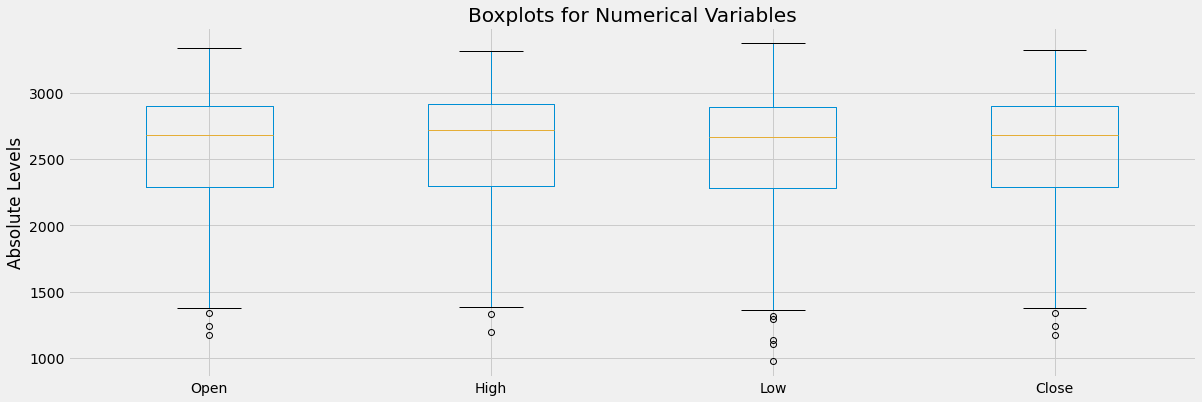

In [27]:
df_stocks.iloc[:,:4].plot.box(figsize=(18, 6))
plt.title("Boxplots for Numerical Variables")
plt.ylabel("Absolute Levels")

In [28]:
hlm = df_stocks.Open + df_stocks.Close / 2
hlm.describe()

count    1215.000000
mean     3889.467325
std       591.857357
min      1843.933317
25%      3440.256292
50%      4032.951877
75%      4355.962845
max      4993.527346
dtype: float64

In [30]:
df_stocks.Label.value_counts()

-1    0
0     0
1     0
Name: Label, dtype: int64

In [31]:
df_stocks

,Open,High,Low,Close,Volume,month,weekday,semes,Label
2011-09-02,1924.610575,1916.393353,1874.891249,1774.765164,1.129876e+08,9,4,1,NaN
2011-09-06,1774.108102,1674.075356,1584.581688,1536.728539,1.116886e+08,9,1,1,NaN
2011-09-07,1534.866113,1465.171247,1364.457399,1500.939730,1.556556e+08,9,2,1,NaN
2011-09-08,1500.781668,1720.381634,1657.602193,1825.507091,1.031916e+08,9,3,1,NaN
2011-09-09,1826.863367,1769.744756,1788.102364,1660.630500,1.120220e+08,9,4,1,NaN
...,...,...,...,...,...,...,...,...,...
2016-06-27,3004.726550,2913.801965,2459.595044,2418.701468,2.081323e+08,6,0,0,NaN
2016-06-28,2382.377694,2325.475820,2277.320727,2288.336736,1.008943e+08,6,1,0,NaN
2016-06-29,2352.022015,2525.422649,2516.452285,2666.596391,7.607727e+07,6,2,0,NaN
2016-06-30,2705.429032,2859.256414,2798.692069,2932.334435,7.185383e+07,6,3,0,NaN


In [ ]:
labels = ["Positivo", "Negativo", "Neutrale"]
colors = sns.color_palette('pastel')[0:3]
plt.pie(df_stocks["Label"].value_counts(), labels = labels, colors = colors, autopct='%.0f%%');

In [ ]:
df_stocks["Label"].value_counts()

The axiom so often coined in financial media "Sell in May, go away, come again St. Leger's day (September 15)"

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 16))
fig.suptitle('** Distribuzioni variabili numeriche **', fontsize=20)


for col, ax in zip(df_stocks.iloc[:,:5], axes.flat):
    sns.distplot(df_stocks[col], color="blue", hist=True, ax=ax)
    
fig.tight_layout()
fig.delaxes(axes[1, 2])

In [ ]:
Il "fractional differencing"

In [ ]:
semes_labels: { 0: "go away", 1: "come again" }
df_stocks["Label"].groupby(df_stocks["semes"]).value_counts()

for i in [0, 1]:
    plt.pie(df_stocks["Label"].groupby(df_stocks["semes"]).value_counts()[0])

In [ ]:
df_stocks["Label"].groupby(df_stocks["weekday"]).value_counts().plot.pie()

In [ ]:
g = sns.displot(df_stocks, x=df_stocks["weekday"], bins=20, multiple="dodge", stat="density");

In [ ]:
plt.figure(figsize=(6,4))

corr = df_stocks.iloc[:, :5].corr(method = 'spearman')
mask = np.triu(corr)
sns.heatmap(corr, square=False, mask=mask, annot = True, vmax=1, vmin=-1, linecolor="white", linewidths=0.5, cmap = "RdBu");

In [ ]:
df_stocks["Label"].groupby(df_stocks["semes"]).value_counts()

In [ ]:
 Maggio a Ottobre rispetto al periodo da Novembre ad Aprile.

In [ ]:
df_stocks.iloc[0:4]

## NLP

In [ ]:
news = pd.read_csv("archive/Combined_News_DJIA.csv", parse_dates=['Date'], index_col=["Date"]).drop('Label', axis=1, inplace=False)
# news["Label"] = news["Label"].astype("category")

In [ ]:
news.sample(1)

In [ ]:
is_NaN = news.isnull()
row_has_NaN = is_NaN.any(axis=1)
col_has_NaN = is_NaN.any(axis=0)
cells_with_NaN = news.loc[row_has_NaN, col_has_NaN]

print('---------------------------------------')
print(f'  NaN: {news.isnull().sum().sum(axis=0)}')
print(f' Cols:',*news.columns[col_has_NaN == True])
print(f'Index:', *cells_with_NaN.index.date)
print('---------------------------------------')

cells_with_NaN.head()

In [ ]:
# inplace=True for slice of a dataframe won't work. It works on complete dataframe.
news.loc[row_has_NaN, col_has_NaN] = news.loc[row_has_NaN, col_has_NaN].fillna("", inplace=False)

print('---------------------------------------')
print(f'  NaN: {news.isnull().sum().sum(axis=0)}')
print('---------------------------------------')

## Suddivisione dati

In [ ]:
news_cols = [f"Top{i}" for i in range(1, 26)]

def aggregate(l=0, a=0):
    """
    Parameters:
    ---------------------
    l: (int) shift for a (1+l) value
    a: (int) aggregate for (a) value
    ---------------------
    Returns:
    ---------------------
    one column news (data frame)
    ---------------------
    """
    
    news[news_cols] = news[news_cols].apply(lambda col: col.shift(1+l))
    news.dropna(inplace=True)

    return pd.Series([str(news[news_cols][max(0, line - a) : line + 1].values.ravel('F')) 
                         for line, _ in enumerate(news.itertuples())], name='News', index=news.index)

In [ ]:
try: X
except NameError: X = aggregate(0, 0)
try: y
except NameError: y = news.Label2

In [ ]:
filters = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',",",'~' , '—', 'b']

for i in range(X.size):
    for filter in filters:
        X[i] = X[i].replace(filter, '').strip()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, shuffle=False, random_state=rnd_state)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, shuffle=False, random_state=rnd_state)

In [ ]:
tss = TimeSeriesSplit(3)

for i, (train, val) in enumerate(tss.split(X), start=1):
    print("FOLD {}".format(i))
    train_dates = X.index[train]
    val_dates = X.index[val]
    print("Training set da {} a {}".format(train_dates.min(), train_dates.max()))
    print("Validation set da {} a {}".format(val_dates.min(), val_dates.max()))

## Classificatore casuale

In [ ]:
sns.displot(stocks["Delta"], aspect=3, kind="kde", color="blue");

In [ ]:
np.random.seed(rnd_state)
random_preds = np.random.normal(y_train.mean(), y_train.std(), len(y_val))

random_preds = np.clip(list(map(lambda a : round(a), random_preds)), -1, 1)

In [ ]:
((random_preds == y_val) * 1).sum()/len(y_val)

## NLP

In [ ]:
gpu_X_train = cudf.Series.from_pandas(X_train)
gpu_y_train = cudf.Series.from_pandas(y_train)
gpu_X_test = cudf.Series.from_pandas(X_test)
gpu_y_test = cudf.Series.from_pandas(y_test)

In [ ]:
from cuml.preprocessing.text.stem import PorterStemmer
stoplist = nltk.corpus.stopwords.words("english")
stemmer = PorterStemmer()

In [ ]:
def my_scorer(y_true, y_predicted):
    error = math.sqrt(np.mean((y_true - y_predicted)**2))
    return error

In [ ]:
def my_tokenizer(text):
    return [stemmer.stem(token.lower()) for token in nltk.tokenize.word_tokenize(text) if token not in stoplist]

In [ ]:
from cuml.pipeline import Pipeline
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {
    'penalty': ('l1', 'l2'),
    'C': np.linspace(1, 100, 100, endpoint=False)
}

model1 = TfidfVectorizer(min_df= 3, stop_words='english', ngram_range=(1,1))
model2 = LogisticRegression(C=10, class_weight='balanced')

gs = GridSearchCV(model2, params, cv=tss, verbose=10)

In [ ]:
%%time
vect = model1.fit_transform(gpu_X_train)
gs.fit(vect.toarray(), y_train)
print(f'Migliori iperparametri: {gs.best_params_}')

In [ ]:
vect2 = model1.transform(gpu_X_test)

In [ ]:
gs.score(vect2.toarray(), gpu_y_test)

In [ ]:
from cuml.metrics import confusion_matrix
y_pred = gs.predict(vect2.toarray())
cf_matrix = confusion_matrix(y_val, y_pred)

In [ ]:
cf_matrix

In [ ]:
y_pred_prob = gs.predict_proba(vect2.toarray())

In [ ]:
predicted_true = np.where(y_pred_prob > 0.90)[0]

In [ ]:
print(f"istanze train: {y_train.size}, istanze val: {y_val.size}, istanze prob 0.70: {predicted_true.size}")

In [ ]:
print(f"l''algoritmo di classificazione predice con sicurezza: {(y_pred[predicted_true] == gpu_y_test.iloc[predicted_true]).sum()/predicted_true.size}")

In [ ]:
gpu_y_test.iloc[predicted_true]